In [1]:
import plotly   # импортируем важные библиотеки, которые будем использовать дальше
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.offline as pyo
from pytrends.request import TrendReq
import pytrends
import pandas as pd
import configparser
import logging
from logging import Formatter
from logging.handlers import RotatingFileHandler
import mysql.connector
import mysql.connector
import matplotlib.pyplot as plt
import time
import geopandas as gpd
import os
import datetime as dt

In [ ]:
# Как уже было сказано, при парсинге Селениумом Яндекс с течением времени начал банить, поэтому спарсить удалось не очень много.
# Однако можно изучить сохранившиеся при ранней работе csv файлы.

In [ ]:
# Здесь мы читаем настройки из файла и инициализиурем объект парсера настроек
config = configparser.RawConfigParser()
config.read('conf.ini', encoding='utf-8')

try:
# Здесь мы инициализируем обьект логгера и задаем ему настройки
    logger = logging.getLogger('logger')
    logger.setLevel(config.get('LOGGING', 'level'))
    handler = RotatingFileHandler(config.get('LOGGING', 'filename'), maxBytes=1000000, backupCount=10)
    formatter = Formatter(fmt='[%(asctime)s] %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S', )
    handler.setFormatter(formatter)
    logger.addHandler(handler)

    # получаем данные из файла настроек
    yandex_data = config.get('FOLDERS', 'yandex_data')  # каталог для исходящих данных
    google_data = config.get('FOLDERS', 'google_data')  # каталог для архивного хранения исходящих данных
    yandex_login = config.get('TOKENS', 'yandex_log')
    yandex_password = config.get('TOKENS', 'yandex_pass')
    selenium_executor = config.get('FOLDERS', 'selenium_executor')  # каталог с входными файлами
    create_db_sql = config.get('SQL', 'create_db')  # путь до большого скрипта, необходимого при загрузке
    unis = config.get('SQL', 'unis')
    # Строки подключения к базам данных
    cnx = mysql.connector.connect(
        host=config.get('DB', 'host'),
        user=config.get('DB', 'user'),
        password=config.get('DB', 'sql_pass'),
        database="webscrapper"
    )  # конфиг для подключения к базам данных
except Exception as e:
    print('can not get params from ini, exit: {ex}'.format(ex=str(e)))

In [ ]:
# Считываем файлы Яндекса (те, что успели спарсить Селениумом)
yandex_harvard = pd.read_csv(f"{yandex_data}{os.sep}harvard.csv") #для Гарварда
yandex_synergy = pd.read_csv(f"{yandex_data}{os.sep}университет синергия.csv") #для Синергии

In [ ]:
# Смотрим на полученный файл. Абсолютное значение в количестве запросов.
yandex_synergy

,Период,Абсолютное,Относительное
0,11.04.2022-17.04.2022,11752.0,"0,000004093262"
1,18.04.2022-24.04.2022,11007.0,"0,000003876341"
2,25.04.2022-01.05.2022,9328.0,"0,000003463586"
3,02.05.2022-08.05.2022,7131.0,"0,000002803944"
4,09.05.2022-15.05.2022,8705.0,"0,000003175733"
5,16.05.2022-22.05.2022,10950.0,"0,000003798015"
6,23.05.2022-29.05.2022,12654.0,"0,000004564023"
7,30.05.2022-05.06.2022,12856.0,"0,000004969486"
8,06.06.2022-12.06.2022,14084.0,"0,000005599495"
9,13.06.2022-19.06.2022,16265.0,"0,000006468331"


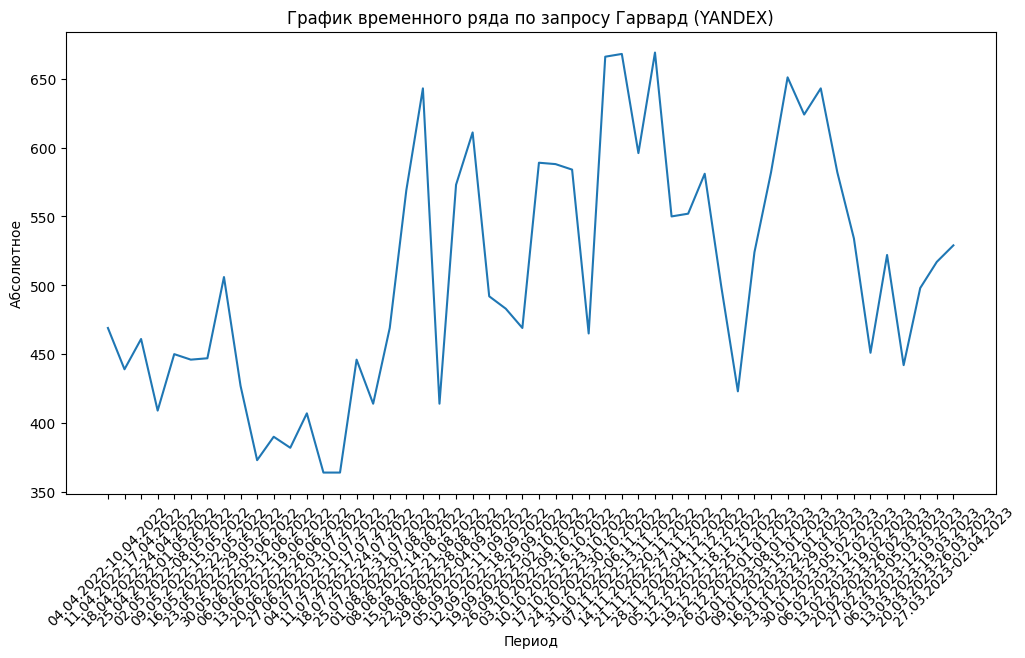

In [ ]:
# рисуем график для Гарварда
plt.figure(figsize=(12, 6))
plt.plot(yandex_harvard['Период'], yandex_harvard['Абсолютное'])
# меняем угол, чтобы все даты вместились
plt.xticks(rotation=45)
# добавляем заголовок и метки осей
plt.title('График временного ряда по запросу Гарвард (YANDEX)')
plt.xlabel('Период')
plt.ylabel('Абсолютное значение')

# смотрим
plt.show()

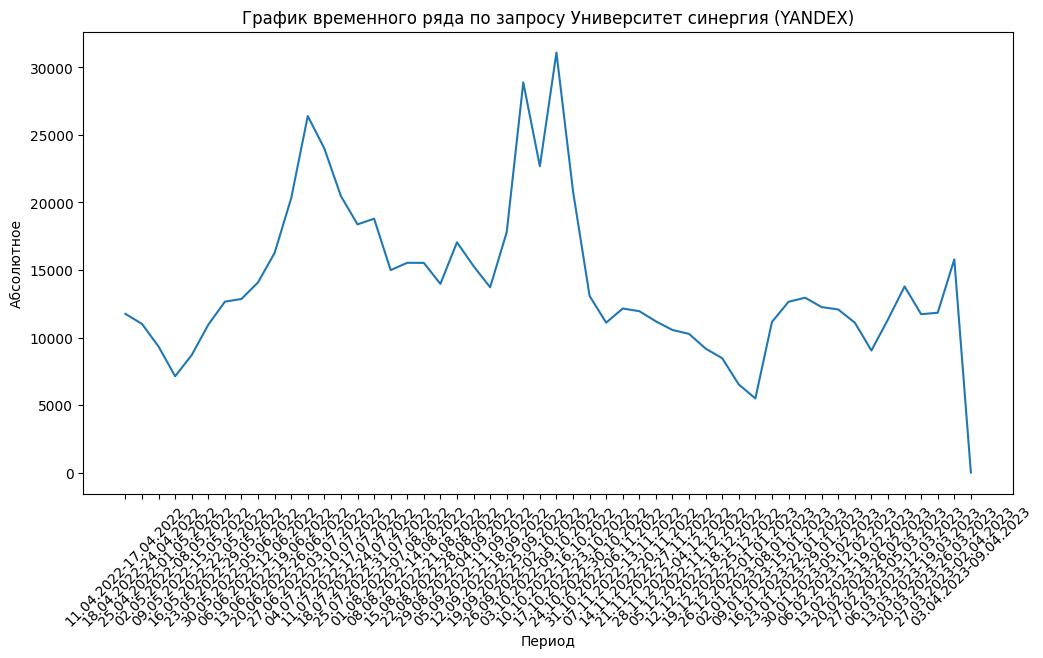

In [ ]:
#  график для Синергии
plt.figure(figsize=(12, 6))
plt.plot(yandex_synergy['Период'], yandex_synergy['Абсолютное'])
# меняем угол, чтобы все даты вместились
plt.xticks(rotation=45)
# добавляем заголовок и метки осей
plt.title('График временного ряда по запросу Университет синергия (YANDEX)')
plt.xlabel('Период')
plt.ylabel('Абсолютное значение')

plt.show()

In [ ]:
try:
    # Инициализируем обьект курсора чтобы общаться с базой
    cursor = cnx.cursor()
    
    # Получаем данные из базы (локальной)
    query = """
    SELECT * FROM
        webscrapper.universities
    
    """
    cursor.execute(query)
except Exception as e:
    # логгируем ошибку подключения к БД
    logger.error(f"DB connect error: {e}")

In [ ]:
# Преобразуем ответ от базы в читаемый питоном вид
sql_data = list(cursor.fetchall())

In [ ]:
# проверка
sql_data[1][0]

'Университет боккони'

In [ ]:
# Создаем пустой массив, чтобы потом в него записывать данные
kw_list = []

In [ ]:
# Смотрим на полученные университеты
for x in (sql_data):
    kw_list.append(x[1])
    print(x[0])
    selenium_scrapper(selenium_executor,x[0],yandex_login, yandex_password, yandex_data)

Гарвардский университет
Университет боккони
Лондонская школа экономики и политических наук
Парижский университет
массачусетский технологический институт
Университет Стэнфорд
Венский университет
МГУ
МФТИ
МИФИ
вшэ
Университет Эрасмус


In [22]:
# Преобразуем в сжатый вид наш лист, чтобы построить график
kw_group = list(zip(*[iter(kw_list)]*1))
kw_grplist = [list(x) for x in kw_group]
trendshow = TrendReq(hl='en-US', tz=360)
dict = {}
i = 0
for kw in kw_grplist:
    trendshow.build_payload(kw, timeframe = 'today 12-m')
    dict[i] = trendshow.interest_over_time()
    i += 1

trendframe = pd.concat(dict, axis=1)
trendframe.columns = trendframe.columns.droplevel(0)
trendframe = trendframe.drop('isPartial', axis = 1)
trendframe



init_notebook_mode(connected=True)

trace = [go.Scatter(
x = trendframe.index,
y = trendframe[col], name=col) for col in trendframe.columns]

data = trace
layout = go.Layout(title='Популярность поисковых запросов к университетам 2022-09-01 - avg начало приемной для большинства вузов', showlegend=True)
fig = go.Figure(data=data, layout=layout)
fig.add_vline(x='2022-09-01', line_dash='dash', line_color='black')

Интерактивный график (прикрепила картинку, так как при сохранении в ipynb в гите график не отображался :(  однако в линамическом варианте его можно посмотреть и использовать если открыть файл dynamic.html -  там этот же график))


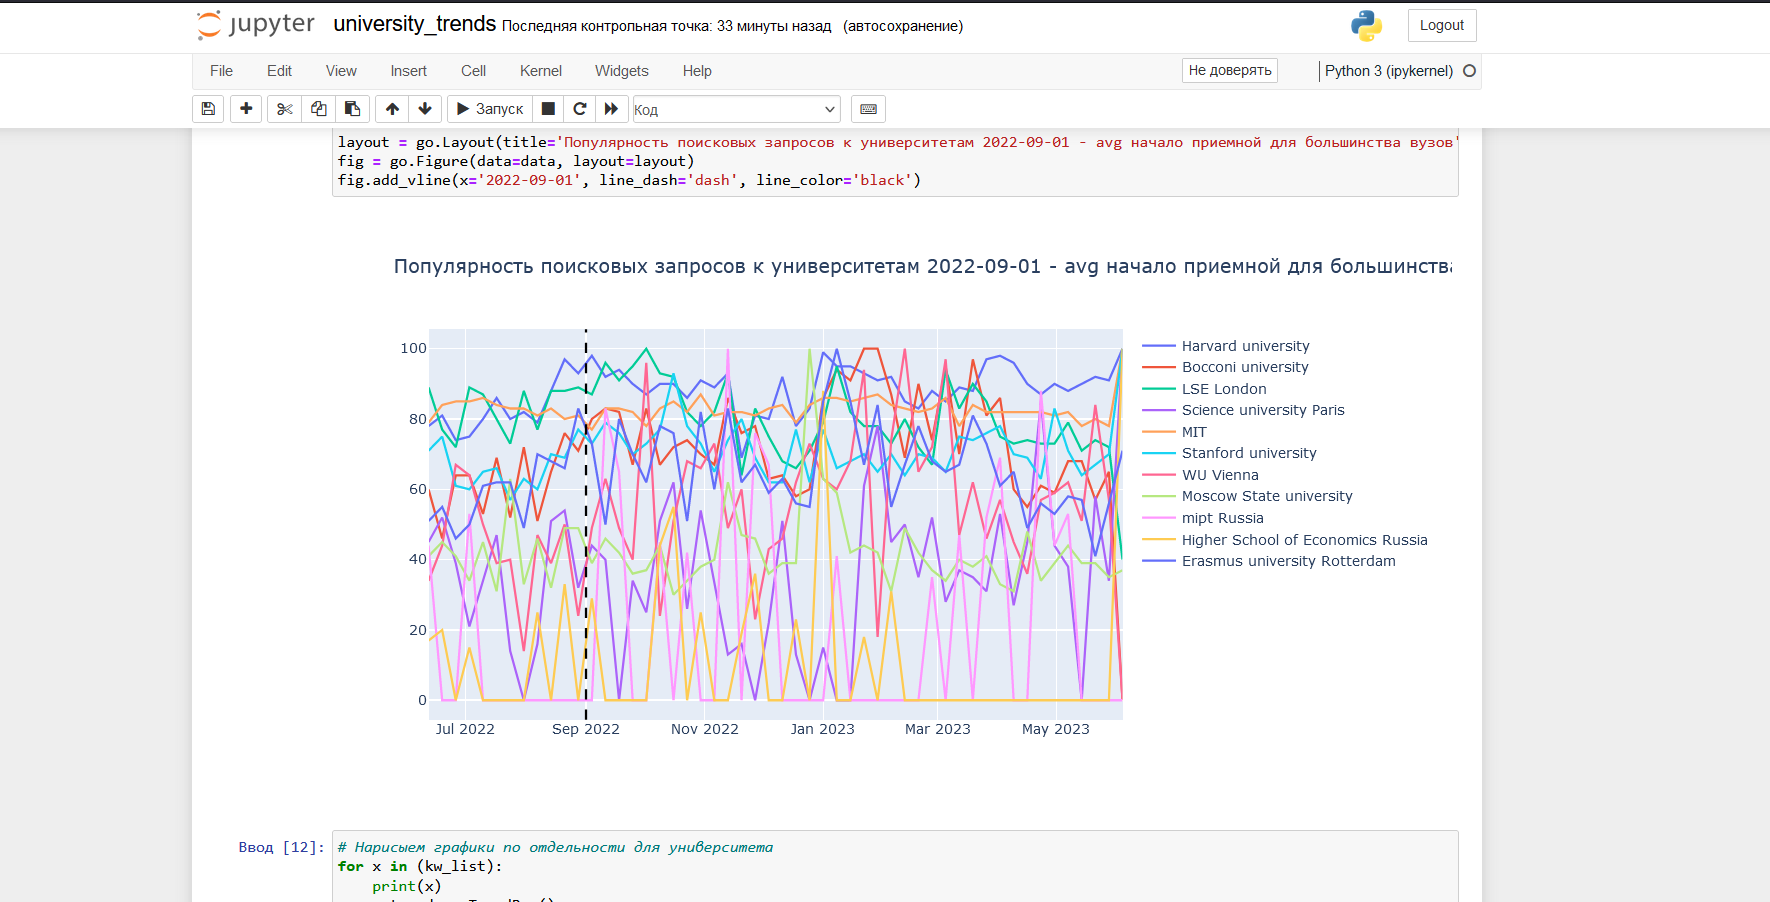

In [23]:
from IPython.display import Image, display, HTML
print('Интерактивный график (прикрепила картинку, так как при сохранении в ipynb в гите график не отображался :(  однако в линамическом варианте его можно посмотреть и использовать если открыть файл dynamic.html -  там этот же график))')
Image("data.png", width=3200, height=2400)

Harvard university: Date of applying: 2022-09-01


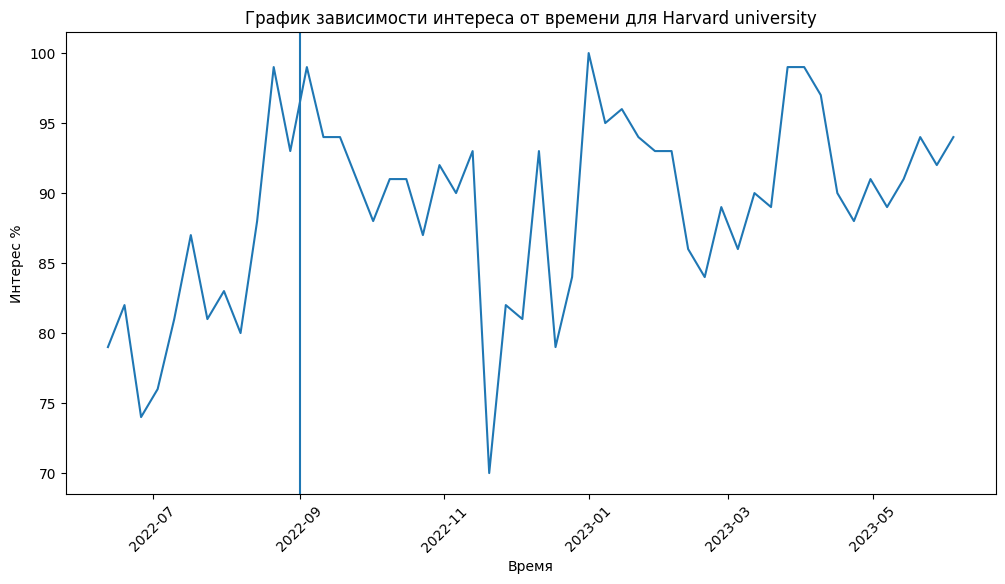

Bocconi university: Date of applying: 2022-09-01


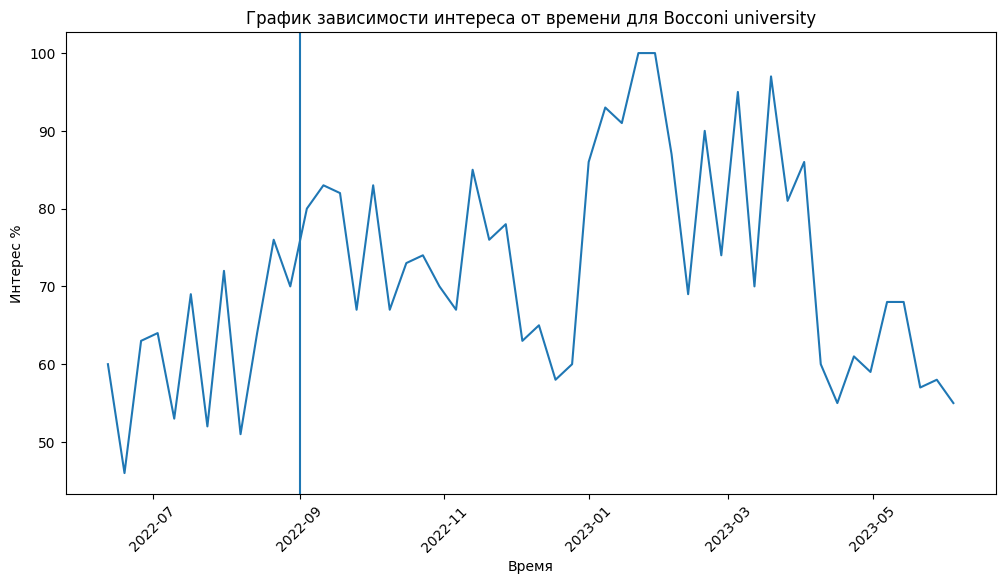

LSE London: Date of applying: 2022-09-01


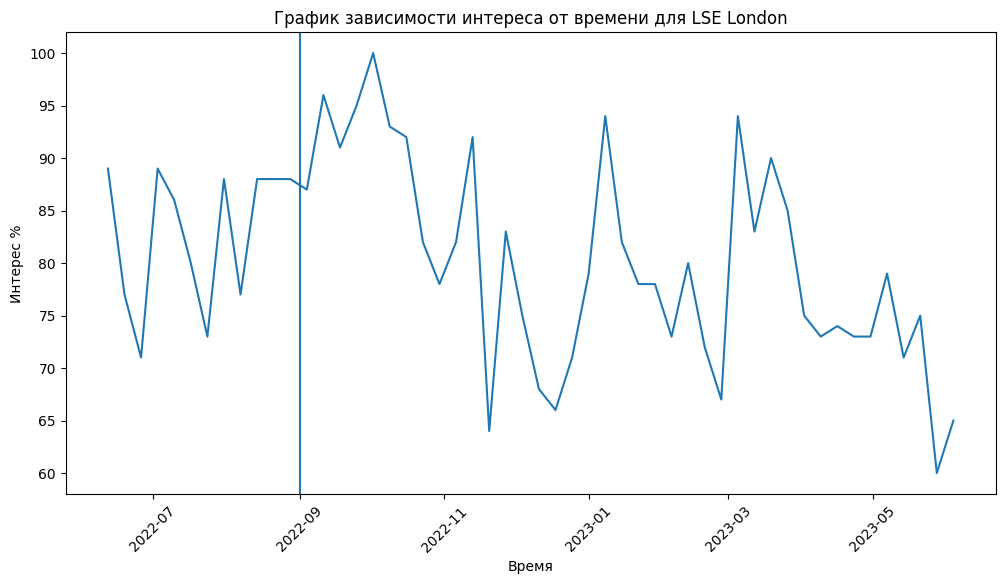

Science university Paris: Date of applying: 2022-06-01


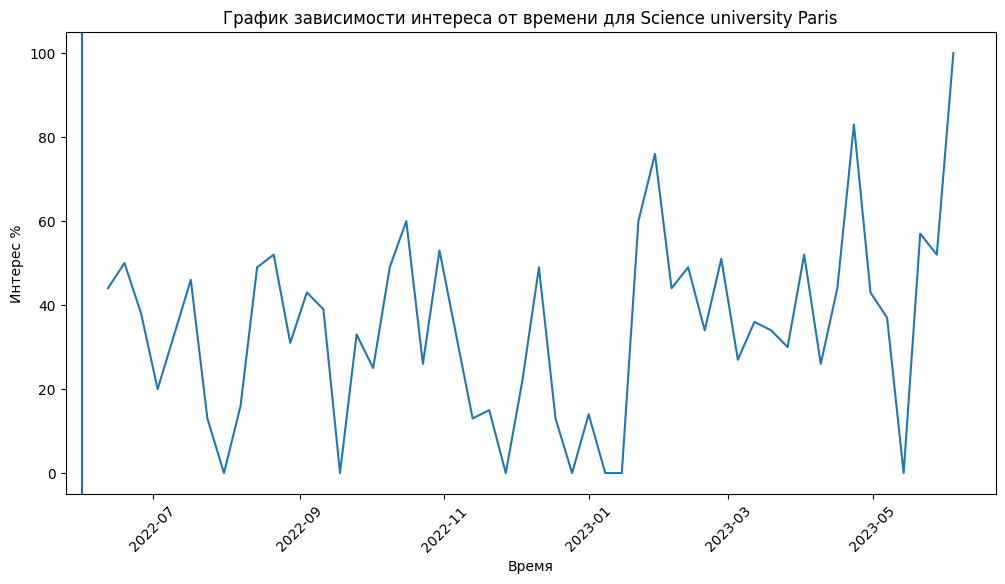

MIT: Date of applying: 2022-09-01


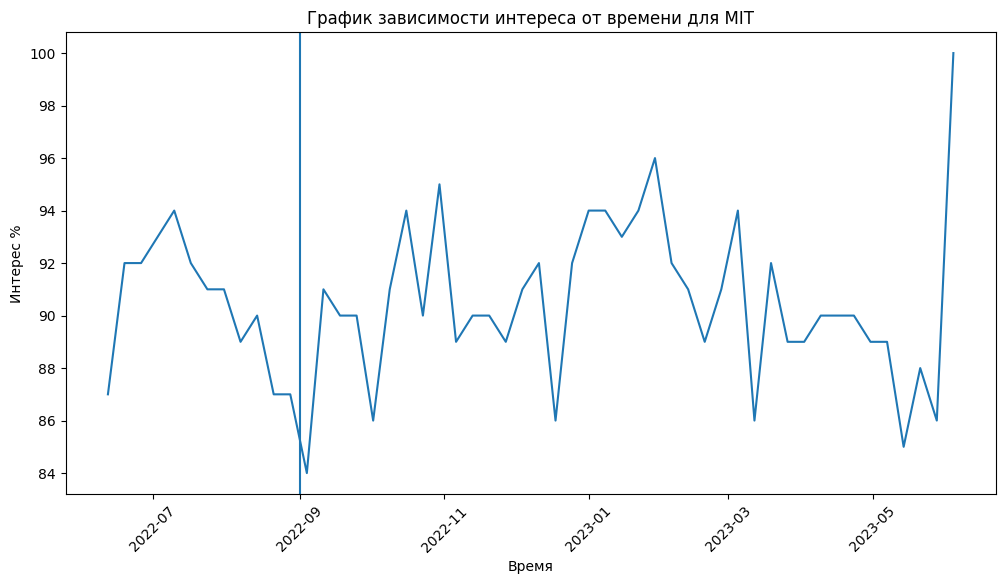

Stanford university: Date of applying: 2022-09-01


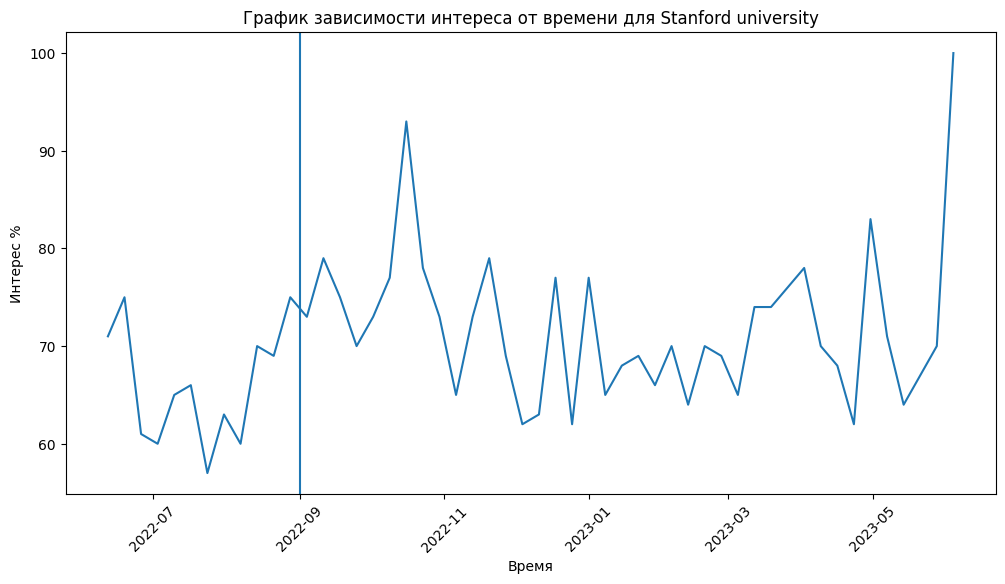

WU Vienna: Date of applying: 2022-07-01


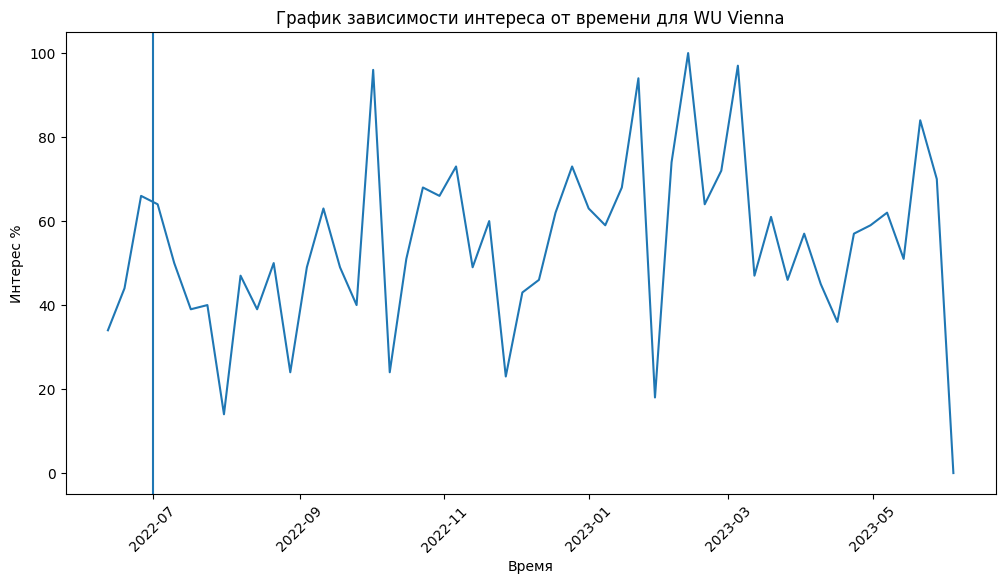

Moscow State university: Date of applying: 2022-07-01


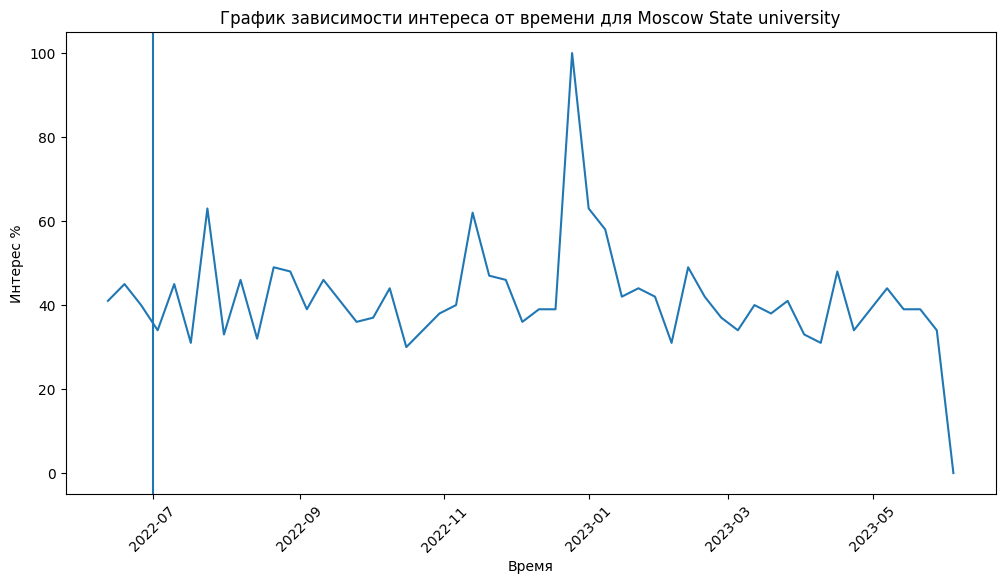

mipt Russia: Date of applying: 2022-06-01


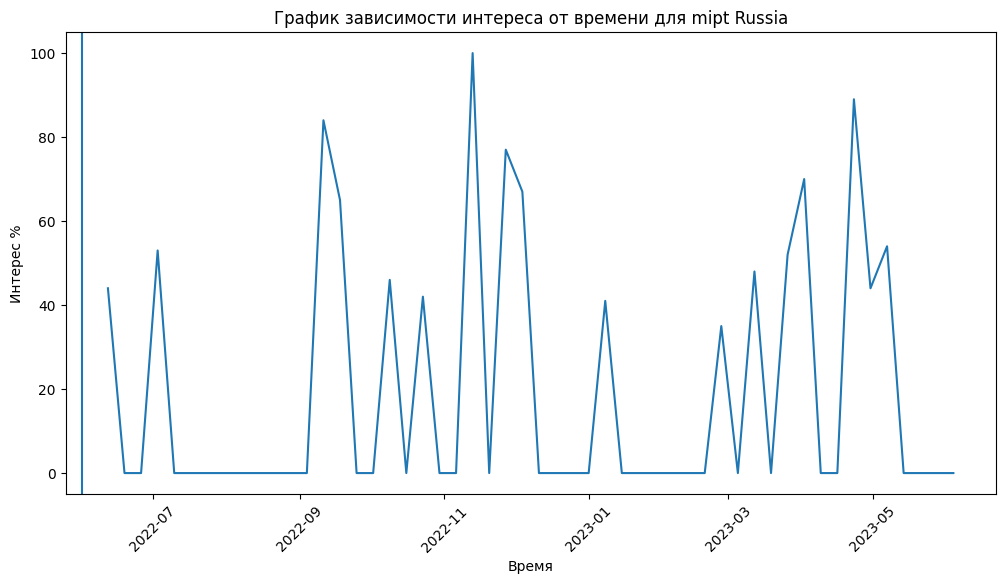

Nuclear University Russia: Date of applying: 2022-06-01


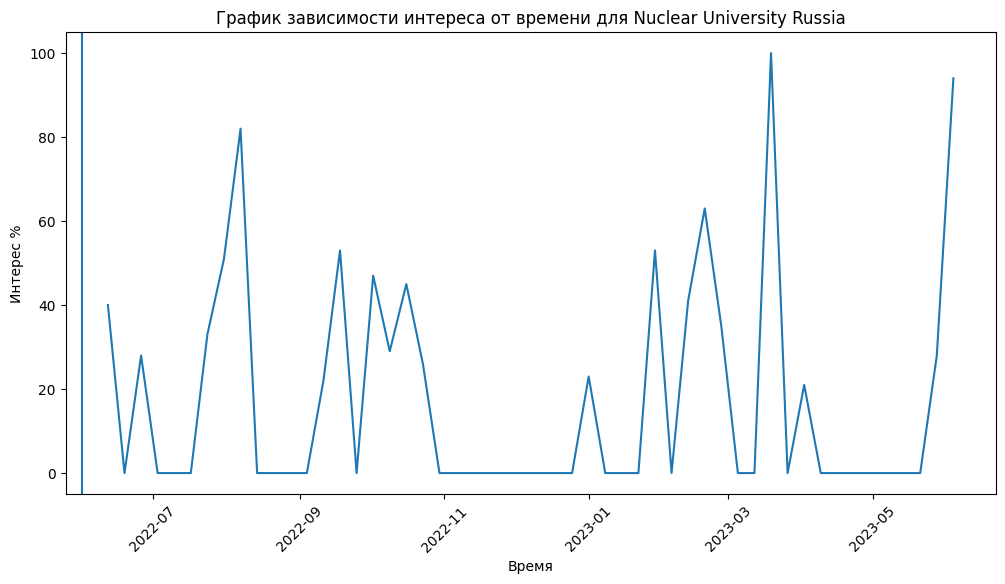

Economics school Russia: Date of applying: 2022-06-01


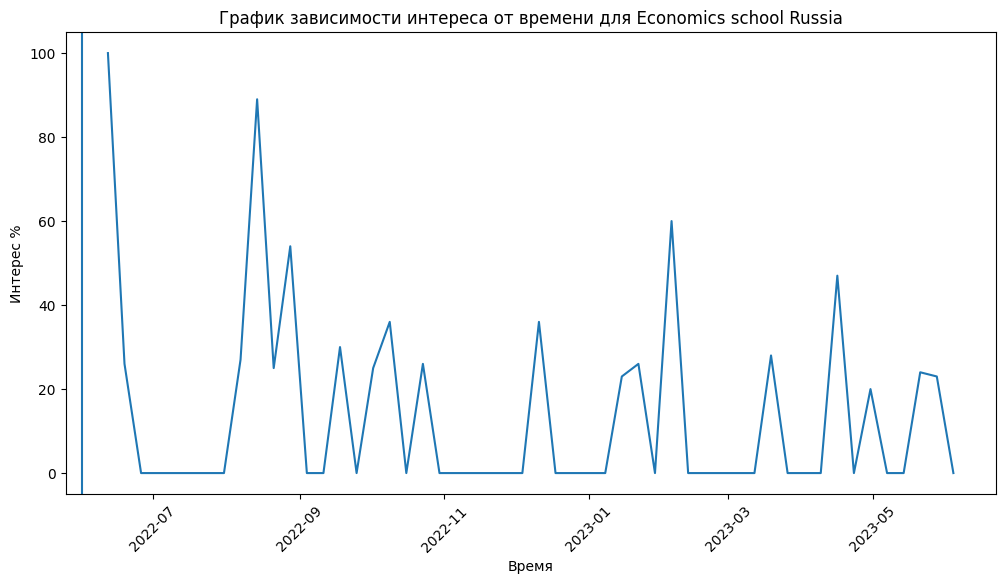

Erasmus university Rotterdam: Date of applying: 2022-09-01


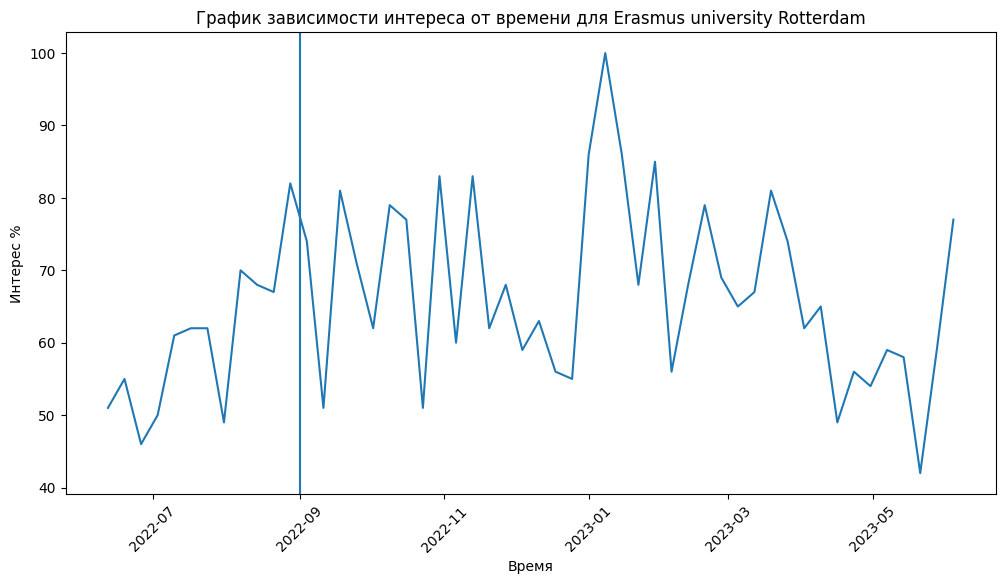

In [16]:
# Нарисуем графики по-отдельности для разных университетов
for item in (kw_list):
    print(F"{item[0]}: Date of applying: {item[1]}")
    pytrends = TrendReq()
    pytrends.build_payload(kw_list=[item[0]], timeframe = 'today 12-m')
    interest_over_time_df = pytrends.interest_over_time()
    # Выведем дата-фрейм, полученный по запросу
    interest_over_time_df["date_helper"] = interest_over_time_df.index.date
    plt.figure(figsize=(12, 6))
    plt.plot(interest_over_time_df["date_helper"], interest_over_time_df[item[0]])
    plt.xticks(rotation=45)
    # Мини костыль была вынуждена применить чтобы обработать данные от Гугл
    plt.axvline(dt.datetime(int(item[1][0:4]), int(item[1][5:7]), int(item[1][8:10])))
    plt.title(f'График зависимости интереса от времени для {item[0]}')
    plt.xlabel('Время')
    plt.ylabel('Интерес %')
    plt.show()
    # Спим, чтобы Гугл не забанил
    time.sleep(3)

%%html
<div style="background-color: #f2f2f2; padding: 20px; font-size: 24px;">
Так как объект карты в рамках одной ячейки не дает вырисовать много отдельных карт, то нарисуем их все по отдельности
</div>

Harvard university


C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\1704941736.py:10: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



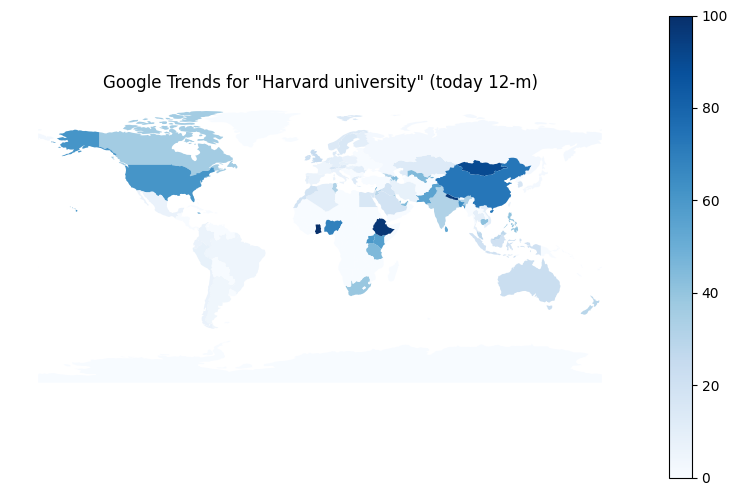

In [ ]:
# Выставляем временной промежуток, за который мы хотим получить данные по АПИ
timeframe = 'today 12-m'
# Инициализируем массив данных
keyword = sql_data[0][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
# Меняем название некоторых стран, так как в датасете геопандас они называются по-другому
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\1404146409.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



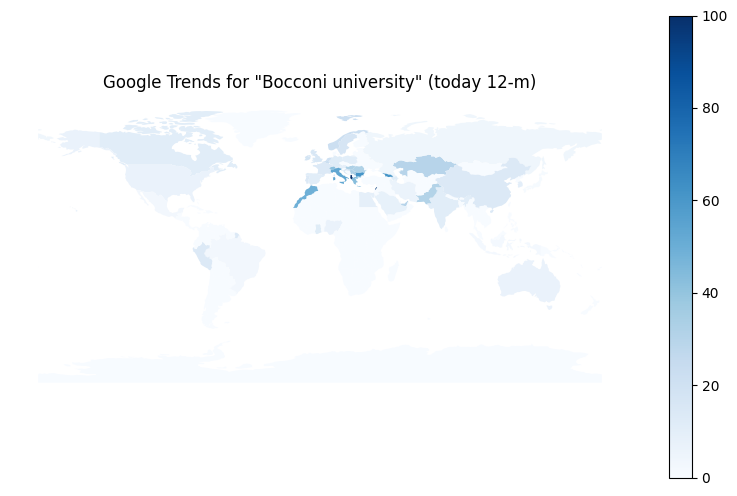

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[1][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\2311554800.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



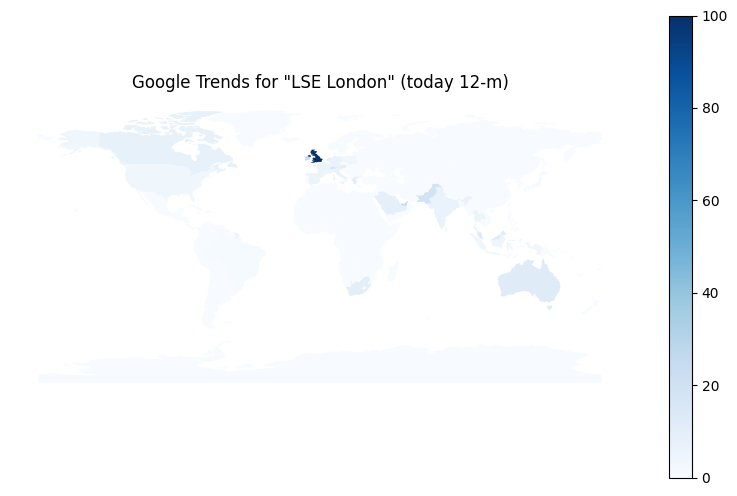

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[2][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\3032639717.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



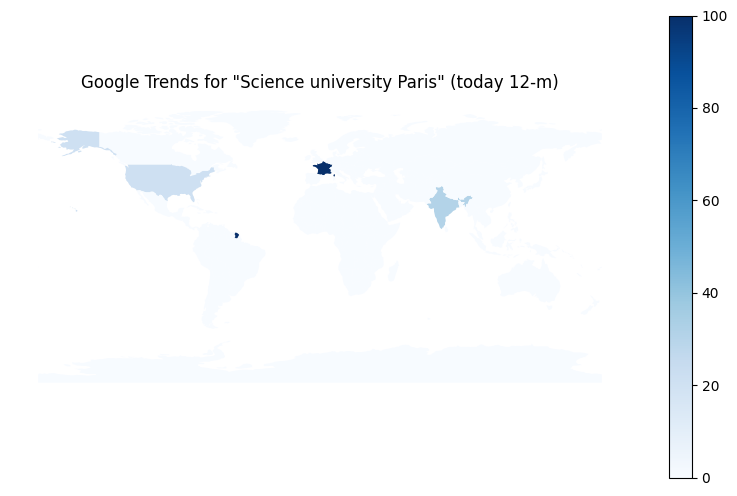

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[3][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\3689273683.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



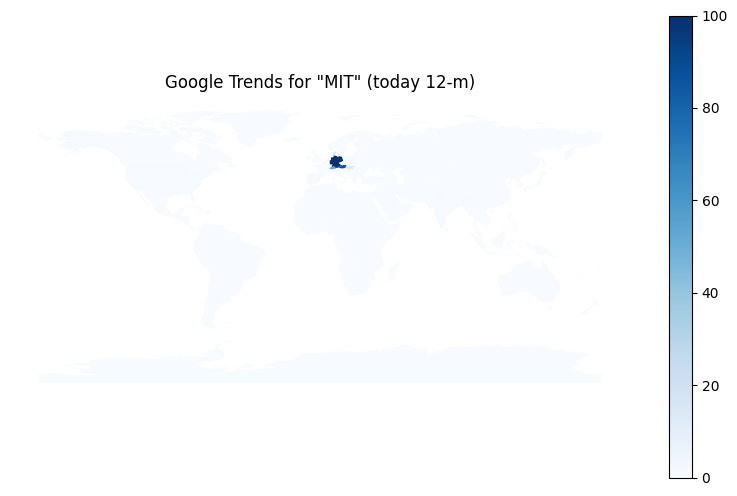

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[4][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\977618603.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



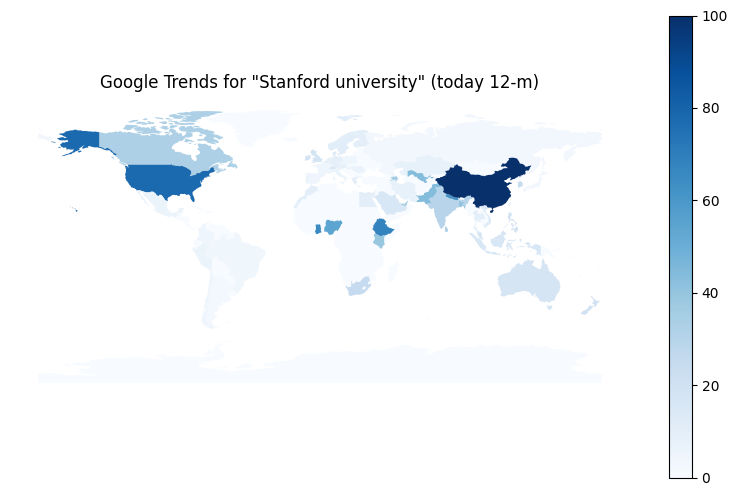

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[5][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\241470280.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



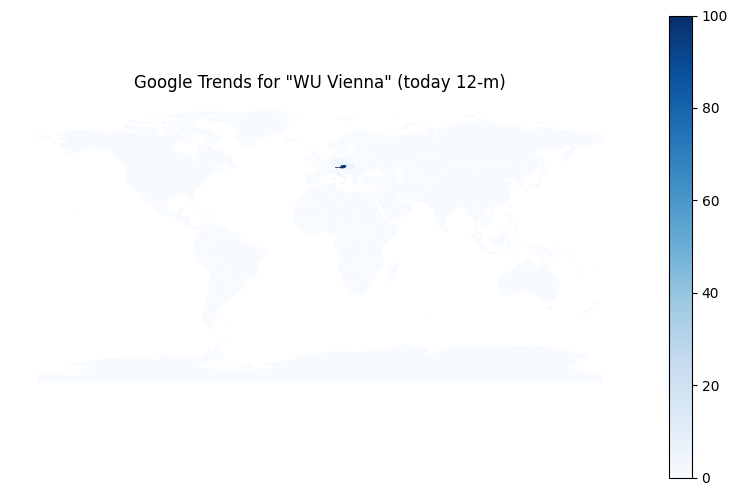

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[6][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\1029640309.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



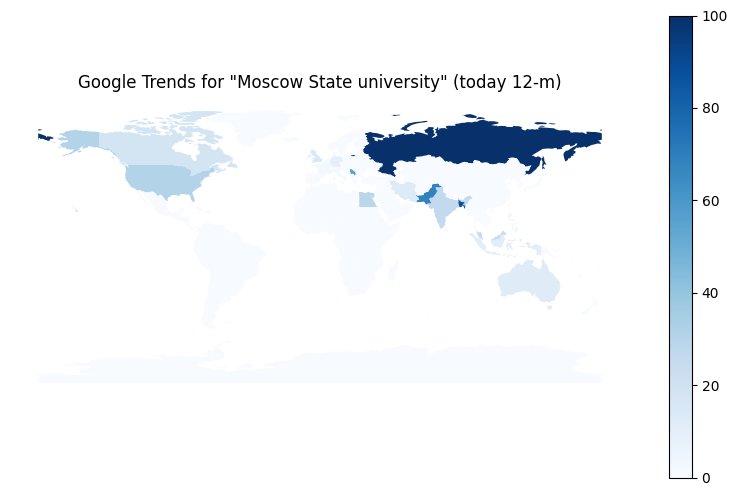

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[7][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\1999017801.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



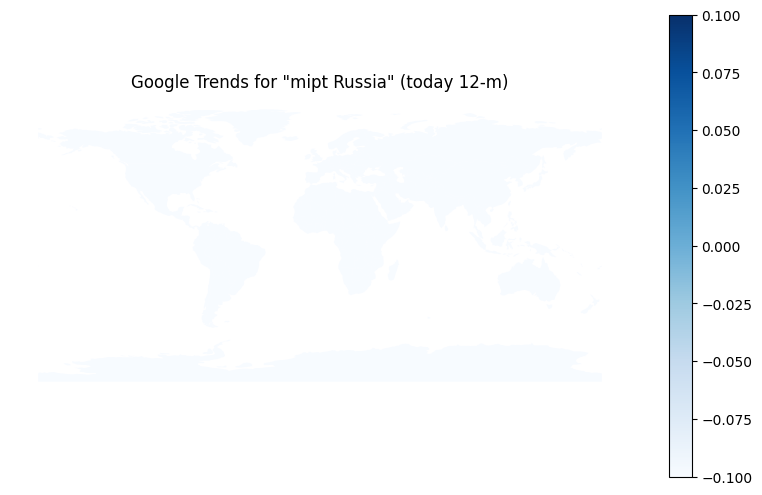

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[8][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\3122429321.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



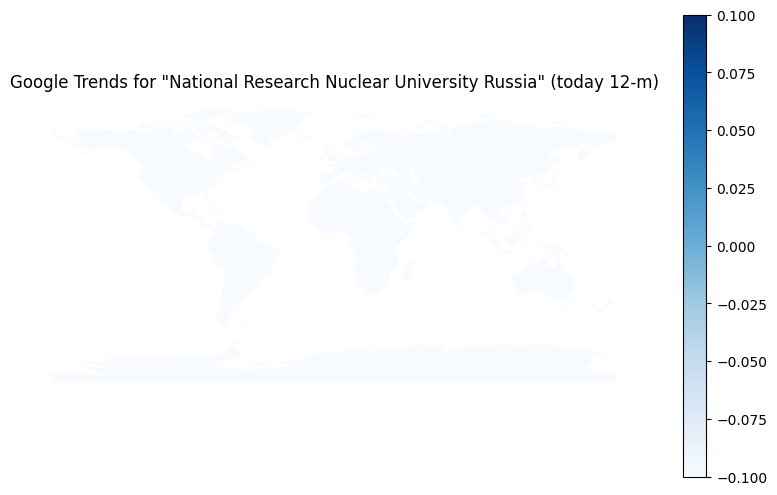

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[9][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\2601618980.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



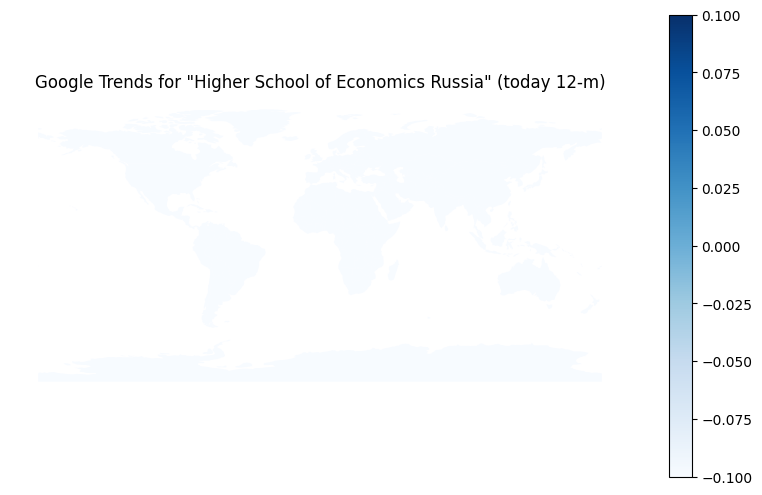

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[10][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

C:\Users\krezn\AppData\Local\Temp\ipykernel_21476\2050079194.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



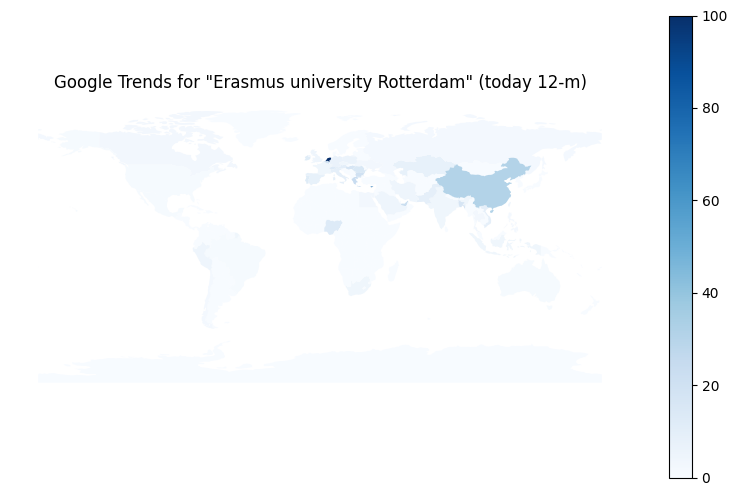

In [ ]:
timeframe = 'today 12-m'
keyword = sql_data[11][1]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='')
data = pytrends.interest_by_region()
interest_over_time_df = pytrends.interest_over_time()
data = data.rename(index={"United States": "United States of America"})
# Меняем название 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='name', right_index=True)
world = world.fillna(0)
world.plot(column=keyword, cmap='Blues', legend=True, figsize=(10, 6))
plt.title(f'Google Trends for "{keyword}" ({timeframe})')
plt.axis('off')
fig = plt.gcf()

In [ ]:
# закрываем коннект к БД
cursor.close()
cnx.close()

In [ ]:
# В целом подводя итог можно сказать что интерес к университетам стабильно держится примерно все время
# и незначительно подрастает во время приемных кампаний
# Так же можно сказать что Наиболее популярны в мире американские университеты тк к ним испытывается наибольший интерес
# судя по поисковым запросам
# Для того чтобы быстро проверить другие гипотезы и теории в удобном интерфейсе можно использовать
# Созданное мной стримлит приложение app.py благодаря нему можно быстро изучить динамику трендов
# даже по нескольким странам и по миру и по любым запросам (не только университеты как тут)

# для этого прочтите ридми и запустите приложение командой из ридми